# Reinforcement Learning
## Teaching an agent to play Blackjack

In this practical work you will have to create an agent that plays the game of Blackjack by using a RL approach.
The agent should learn its own strategy by playing against a dealer with a fixed strategy.

We will give you most of the code. You have to complete the missing lines to make the script actually work.

### States table

These are the representation of the states we used in this example:

State | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 |
:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
Score | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | bust |
Ace |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ | ✔ |

### Install dependencies if needed
The following command will allow you to install gym, which is a toolkit for developing and comparing reinforcement learning algorithms: https://gym.openai.com/


pip install --upgrade git+https://github.com/openai/gym

### Import packages

In [ ]:
import gym
from gym import spaces
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as pl
from matplotlib import colors

### Define the behavior of the game and the agent
The following class will define the agent and the rules of the game. The comments should guide you through the different methods

In [ ]:
class BlackjackEnv(gym.Env):
    '''
    This is a modification of the original implementation in
    https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    '''

    def cmp(self, a, b):                    # Compares two scores
                                            # +1.0 if a > b
                                            # -1.0 if a < b
                                            # 0.0 otherwise
        return float(a > b) - float(a < b)

    def score(self, hand):                  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    def usable_ace(self, hand):             # Does this hand have an usable ace?
        return (1 in hand) and ((np.sum(hand) + 10) <= 21)

    def sum_hand(self, hand):               # Return current hand total
        if self.usable_ace(hand):
            return np.sum(hand) + 10
        else:
            return np.sum(hand)

    def is_bust(self, hand):                # Is this hand a bust?
        return self.sum_hand(hand) > 21

    def draw_card(self):                    # Gives a random card
                                            # 1 = Ace
                                            # 2-10 = Number cards
                                            # Jack/Queen/King = 10
        return int(np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]))

    def draw_hand(self):                    # Gives a hand (two random cards)
        return [self.draw_card(), self.draw_card()]

    def reset(self):                        # Initializes the state (random hand for both player and dealer)
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

    def compute_state_sum(self):
        s = self.sum_hand(self.player)
        if s > 21:                          # Bust
            return self.observation_space[-1].n - 1
        else:
            s = s - 4                       # Minimum sum is 4
            if self.usable_ace(self.player):
                s += 10                     # Add 10 if there is an usable ace
            return s

    def _get_obs(self):
        if self.look_dealer:
            return (self.dealer[0] - 1,     # Minimum card is 1
                    self.compute_state_sum())
        else:
            return (self.compute_state_sum(),)


    def __init__(self, look_dealer=True):
        self.look_dealer = look_dealer      # Use additional states to take into account the dealer's card
        self.reset()

        self.action_space = spaces.Discrete(2)
        if self.look_dealer:
            self.observation_space = spaces.Tuple(
                (spaces.Discrete(10),       # First card of the dealer
                 spaces.Discrete(29))       # States needed to encode the sum of cards
            )                               # 4 to 21 = 18, + 10 if there is an usable ace, + 1 if bust
        else:
            self.observation_space = spaces.Tuple(
                (spaces.Discrete(29),)      # States needed to encode the sum of cards
            )                               # 4 to 21 = 18, + 10 if there is an usable ace, + 1 if bust


    def step(self, action):
        assert self.action_space.contains(action)
        if action:                          # Hit: add a card to players hand and return
            self.player.append(self.draw_card())
            score = self.sum_hand(self.player)
            if score > 21:                  # Bust. If player exceeds 21 the dealer wins automatically
                done = True
                reward = -1.0
            elif score == 21:               # Win. If the player gets 21
                done = True
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                if self.sum_hand(self.dealer) == 21: # If the dealer get to 21, the dealer wins
                    reward = -1.0
                else:
                    reward = 1.0
            else:
                done = False
                reward = 0.0
        else:                               # Stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))

        return self._get_obs(), reward, done, {}


### Create the environment to play

In [ ]:
env = BlackjackEnv(look_dealer=True)

In [ ]:
for d in env.observation_space:
    print(d.n)

10
29


In [ ]:
env.action_space.n

2

In [ ]:
state = env.reset()
print(state)

(9, 16)


### Create the Q table

In [ ]:
if env.look_dealer:
    q_table = np.ones([env.observation_space[0].n,
                       env.observation_space[1].n,
                       env.action_space.n])
else:
    q_table = np.ones([env.observation_space[0].n,
                       env.action_space.n])

print(q_table.shape)

(10, 29, 2)


### Run the learning loop

You have to complete this cell to make the agent learn.

Follow the instructions in the reinforcement learning lesson to compute **delta** and to update the **Q table** accordingly.

Compare the results after using different values of **epsilon**.

In [ ]:
%%time

print('Training the agent')

# Hyperparameters
alpha = 0.1                # Learning rate
gamma = 0.9                # Weight of the predicted reward
epsilon = 0.1              # Probability if exploration
episodes = 1000000         # How many games the agent will play against the dealer

for i in range(1, episodes+1):
    state = env.reset()
    done = False
    if env.sum_hand(env.player) != 21:

        while not done:
            if env.look_dealer:
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()                # Explore action space
                else:
                    action = np.argmax(q_table[state[0], state[1], :])# Exploit learned values

                next_state, reward, done, info = env.step(action)

                old_value = q_table[state[0], state[1], action]
                next_max = np.max(q_table[next_state[0], next_state[1], :])

                # ---------------------------------------------------------
                delta = ??                                 # complete here
                q_table[state[0], state[1], action] += ??  # complete here
                # ---------------------------------------------------------
            else:
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()                # Explore action space
                else:
                    action = np.argmax(q_table[state[0], :])          # Exploit learned values

                next_state, reward, done, info = env.step(action)

                old_value = q_table[state[0], action]
                next_max = np.max(q_table[next_state[0], :])

                # ---------------------------------------------------------
                delta = ??                                 # complete here
                q_table[state[0], action] += ??            # complete here
                # ---------------------------------------------------------

            state = next_state


    if i % 1000 == 0:
        clear_output(wait=True)
        print(f'Episode: {i}')

print('Training finished.\n')

Episode: 1000000
Training finished.

CPU times: user 2min 50s, sys: 6.84 s, total: 2min 56s
Wall time: 2min 45s


### Visualize the Q table

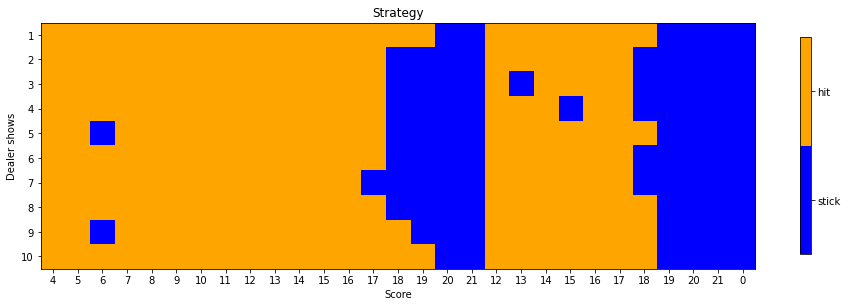

In [ ]:
pl.figure(figsize=(16,10))
cmap = colors.ListedColormap(['blue', 'orange'])

if env.look_dealer:
    im = pl.imshow(np.argmax(q_table, axis=2), cmap=cmap, vmin=-0.5, vmax=1.5)
    pl.yticks(np.arange(q_table.shape[0]), np.arange(q_table.shape[0])+1)
else:
    im = pl.imshow(np.argmax(q_table, axis=1)[np.newaxis,:], cmap=cmap, vmin=-0.5, vmax=1.5)
cbar = pl.colorbar(im, cmap=cmap, ticks=[0, 1], shrink=0.4)
cbar.ax.set_yticklabels(['stick', 'hit'])
score_label = np.arange(q_table.shape[-2]) + 4
score_label[score_label > 21] -= 10
score_label[-1] = 0
pl.xticks(np.arange(q_table.shape[-2]), score_label)
pl.ylabel('Dealer shows')
pl.xlabel('Score')
pl.title('Strategy');

Text(0.5, 1.0, 'Qh - Qs')

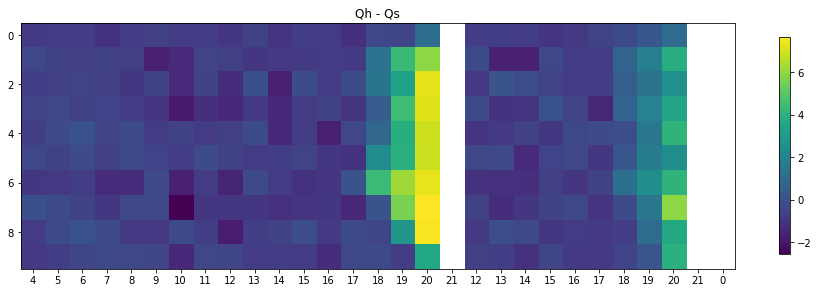

In [ ]:
pl.figure(figsize=(16,10))
temp = q_table[:,:,0] - q_table[:,:,1]
temp[temp == 0] = np.nan
pl.imshow(temp)
pl.colorbar(shrink=0.4)
score_label = np.arange(q_table.shape[-2]) + 4
score_label[score_label > 21] -= 10
score_label[-1] = 0
pl.xticks(np.arange(q_table.shape[-2]), score_label)
pl.title('Qh - Qs')

### Evaluate the performance
You can select whether to evaluate:
- the dealer's strategy: play_like_dealer = True
- random strategy: go_random = True, play_like_dealer = False
- learned strategy: go_random = False, play_like_dealer = False

In [ ]:
print("Evaluate agent's performance after Q-learning")

total_epochs = 0
total_lose = 0
total_win = 0
episodes = 10000

play_like_dealer = False
go_random = False


for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0

    done = False

    while not done:
        if play_like_dealer:
            if env.sum_hand(env.player) < 17:
                action = 1
            else:
                action = 0
        elif go_random:
            action = env.action_space.sample()
        else:
            if env.look_dealer:
                action = np.argmax(q_table[state[0],state[1],:])
            else:
                action = np.argmax(q_table[state[0],:])

        state, reward, done, info = env.step(action)
        epochs += 1

    if reward == -1:
        total_lose += 1
    if reward == 1:
        total_win += 1

    total_epochs += epochs

print(f'Results after {episodes} episodes:')
print(f'Average timesteps per episode: {total_epochs / episodes}')
print(f'Average loses per episode: {total_lose / episodes}')
print(f'Average wins per episode: {total_win / episodes}')

Evaluate agent's performance after Q-learning
Results after 10000 episodes:
Average timesteps per episode: 1.6145
Average loses per episode: 0.55
Average wins per episode: 0.3738


### See how the agent plays a game

In [ ]:
print("Visualizing an individual episode")

state = env.reset()

if env.sum_hand(env.player) == 21:
    done = True
else:
    done = False

while not done:
    if env.look_dealer:
        action = np.argmax(q_table[state[0],state[1],:])
    else:
        action = np.argmax(q_table[state[0],:])
    next_state, reward, done, info = env.step(action)

    print('---------------------')
    print(f'state {state}')
    print(f'action {action}')
    print(f'reward {reward}')
    print(f'next_state {next_state}')

    state = next_state

print()
if env.look_dealer:
    print(f'Dealer gets: {state[0]}, {env.sum_hand(env.dealer)}, {env.dealer}')
    print(f'Player gets: {state[1]}, {env.sum_hand(env.player)}, {env.player}')
else:
    print(f'Dealer gets: {env.sum_hand(env.dealer)}, {env.dealer}')
    print(f'Player gets: {state[0]}, {env.sum_hand(env.player)}, {env.player}')

Visualizing an individual episode
---------------------
state (7, 16)
action 0
reward 1.0
next_state (7, 16)

Dealer gets: 7, 18, [8, 10]
Player gets: 16, 20, [10, 10]
